In [101]:
import yfinance as yf
import mplfinance as mpf
from datetime import datetime, timedelta
import pandas as pd

# Set the parameters that we are interested in
ticker = "QQQ"


current_datetime = datetime.today()
last_60_datetime = current_datetime - timedelta(days=59)
last_7_datetime = current_datetime - timedelta(days=8)
# converting datetime to date
current_date = current_datetime.strftime("%Y-%m-%d")
last_60_day = last_60_datetime.strftime("%Y-%m-%d")
last_7_day = last_7_datetime.strftime("%Y-%m-%d")

In [102]:
# Options
daily_expiration_date = (current_datetime).strftime("%Y-%m-%d")

# Get the options data for the specified ticker and expiration date
options = yf.Ticker(ticker).option_chain(daily_expiration_date)

# Get the latest closing price
#lastest_price = yf.Ticker(ticker).history(period='1d')['Close'][0]
last_close = yf.download(ticker)['Close'][-1]

a = options.calls[options.calls['strike']==round(last_close)]['ask']
b = options.puts[options.puts['strike']==round(last_close)]['ask']
margin = float(a)*1.1 + float(b)*1.1

upper = last_close + margin
lower = last_close - margin


[*********************100%***********************]  1 of 1 completed


## 15 minutes timeframe

In [125]:
raw_df[raw_df.index >= anchor_date]
#.rolling(window=period).apply(lambda x: (x['Close'] * x['Volume']).sum() / x['Volume'].sum(), raw=True)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-02-13 09:30:00,301.130005,301.790009,299.929993,301.410004,301.410004,3753560
2023-02-13 09:45:00,301.428192,302.670013,301.010010,302.570007,302.570007,2186559
2023-02-13 10:00:00,302.579987,302.869995,301.480011,301.859985,301.859985,1858162
2023-02-13 10:15:00,301.880005,302.600006,301.609985,302.545898,302.545898,1988883
2023-02-13 10:30:00,302.545013,302.790009,302.209991,302.589996,302.589996,1339291
...,...,...,...,...,...,...
2023-04-13 10:30:00,317.269989,317.399994,316.625000,316.890015,316.890015,1786284
2023-04-13 10:45:00,316.910004,317.290009,316.620911,316.789307,316.789307,1338529
2023-04-13 11:00:00,316.790009,317.399994,316.790009,317.109985,317.109985,1305881


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


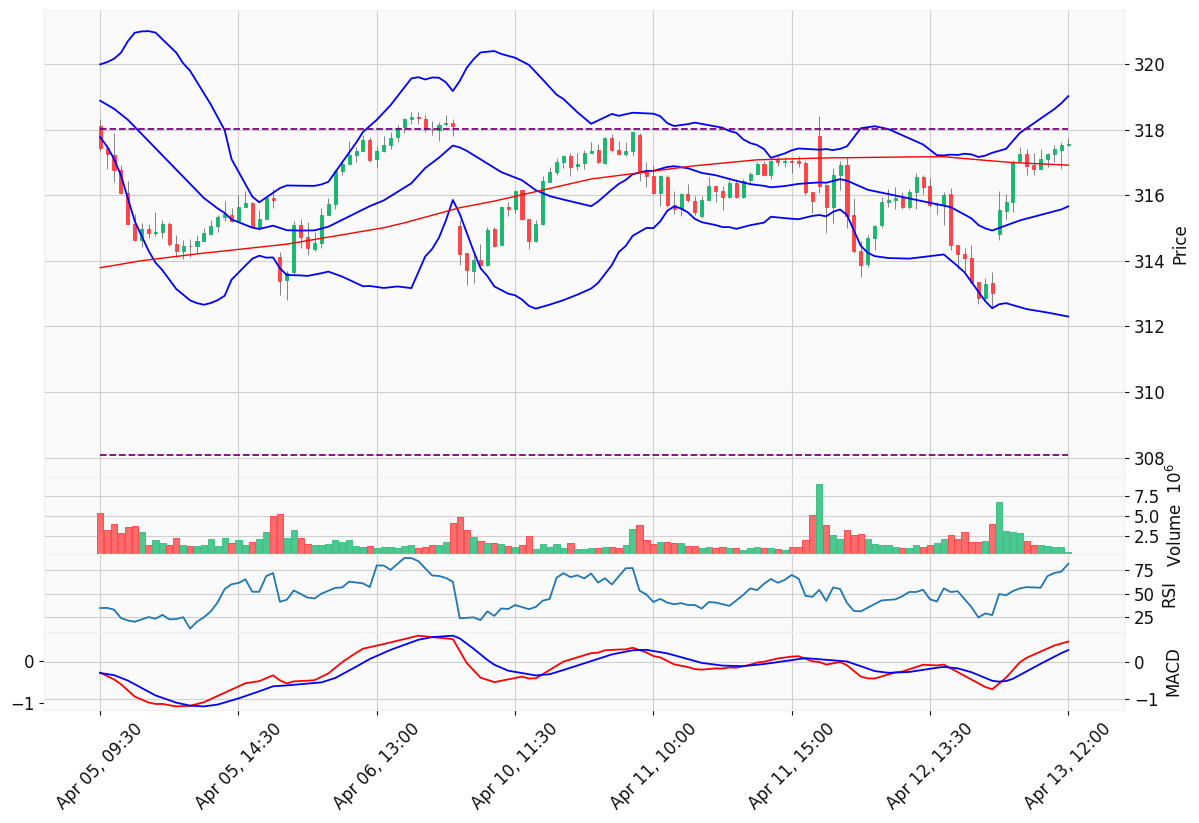

In [133]:
# Download historical data of QQQ from Yahoo Finance
raw_df = yf.download(ticker, start=last_60_day, interval = '15m' )
df = yf.download(ticker, start=last_7_day, interval = '15m')

# Define anchored VWAP parameters
# anchor_date = "2022-04-03"
# period = 20

# Calculate anchored VWAP
#df['AVWAP'] = raw_df[raw_df.index >= anchor_date].rolling(window=period).apply(lambda x: (x['Close'] * x['Volume']).sum() / x['Volume'].sum(), raw=True).dropna()

# Calculate Moving Averages
df['MA20'] = raw_df['Close'].rolling(window=20).mean()
df['MA50'] = raw_df['Close'].rolling(window=50).mean()
df['MA200'] = raw_df['Close'].rolling(window=200).mean()

# Calculate Relative Strength Index (RSI)
delta = raw_df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
fast_ema = 12
slow_ema = 26
signal = 9
exp1 = raw_df['Close'].ewm(span=fast_ema, adjust=False).mean()
exp2 = raw_df['Close'].ewm(span=slow_ema, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['signal_line'] = df['MACD'].ewm(span=signal, adjust=False).mean()

# Calculate Bollinger Bands
df['MA20_STD'] = raw_df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + 2 * df['MA20_STD']
df['Lower_Band'] = df['MA20'] - 2 * df['MA20_STD']

df['upper'] = upper
df['lower'] = lower

# Define style options
style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 12})

# Create the plot with indicators
mpf.plot(df, type='candle', volume=True, #mav = (fast_ema,slow_ema),
         addplot=[
            # Adding the RSI onto the plot
            mpf.make_addplot(df['RSI'], panel=2, ylabel='RSI'),
            # Adding the Bollinger Bands
            mpf.make_addplot(df[['Upper_Band', 'MA20', 'Lower_Band']], panel=0, color = 'blue', ylabel='Bollinger Bands'),
            
            # Moving average
            mpf.make_addplot(df['MA200'], panel=0,color='red',width = 1),
            # MACD
            mpf.make_addplot(df['MACD'], panel=3,color='red', ylabel = 'MACD'), 
            mpf.make_addplot(df['signal_line'], panel = 3,color='blue')

            # Adding daily expected moves
            , mpf.make_addplot(df['upper'], type='line', linestyle='--', color='purple')
            , mpf.make_addplot(df['lower'], type='line', linestyle='--', color='purple')

            # Adding achorVWAP
            #, mpf.make_addplot(df['AVWAP'], color = 'orange', panel = 0)

            ], 
         panel_ratios=(6,1), figsize = (15,10), style = style
        )


## Daily timeframe

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


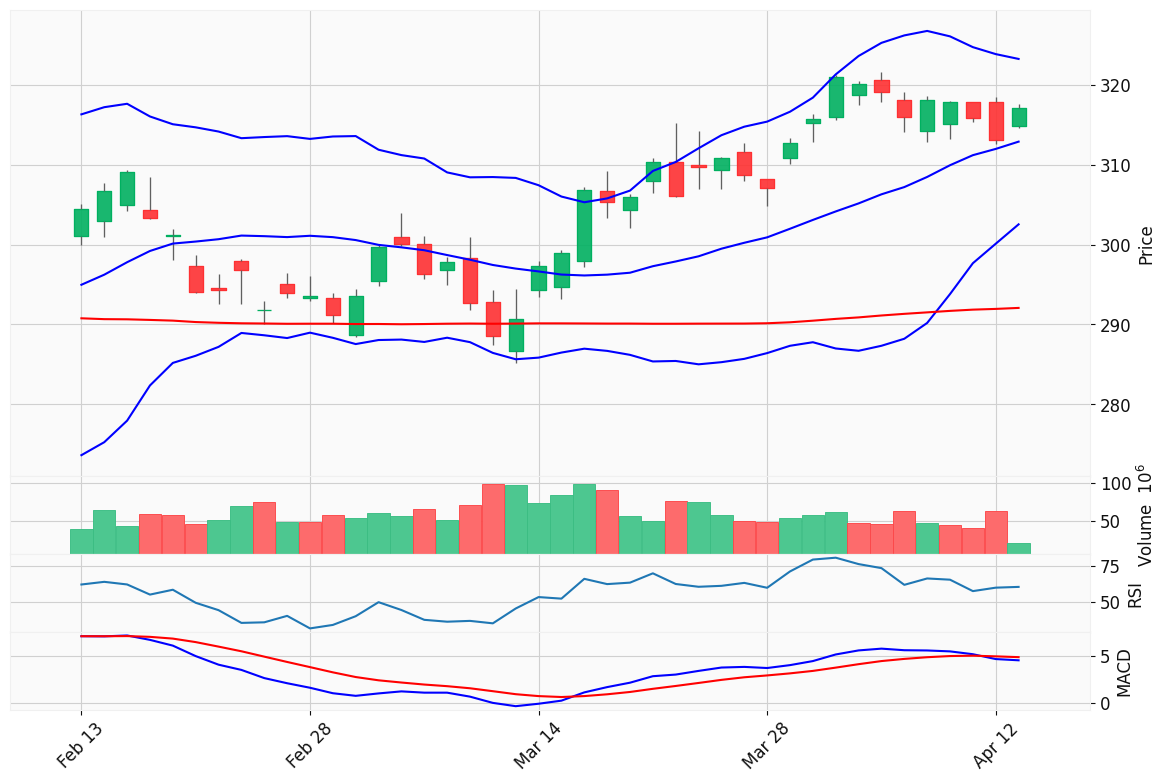

In [113]:
# Download historical data of QQQ from Yahoo Finance
raw_df = yf.download(ticker, start='2022-01-01', interval = '1d' )
df = yf.download(ticker, start=last_60_day, interval = '1d')

# Calculate Moving Averages
df['MA20'] = raw_df['Close'].rolling(window=20).mean()
df['MA50'] = raw_df['Close'].rolling(window=50).mean()
df['MA200'] = raw_df['Close'].rolling(window=200).mean()

# Calculate Relative Strength Index (RSI)
delta = raw_df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
fast_ema = 12
slow_ema = 26
signal = 9
exp1 = raw_df['Close'].ewm(span=fast_ema, adjust=False).mean()
exp2 = raw_df['Close'].ewm(span=slow_ema, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['signal_line'] = df['MACD'].ewm(span=signal, adjust=False).mean()

# Calculate Bollinger Bands
df['MA20_STD'] = raw_df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + 2 * df['MA20_STD']
df['Lower_Band'] = df['MA20'] - 2 * df['MA20_STD']

df['upper'] = upper
df['lower'] = lower

# Define style options
style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 12})

# Create the plot with indicators
mpf.plot(df, type='candle', volume=True, #mav = (fast_ema,slow_ema),
         addplot=[
            # Adding the RSI onto the plot
            mpf.make_addplot(df['RSI'], panel=2, ylabel='RSI',width = 1.5),
            # Adding the Bollinger Bands
            mpf.make_addplot(df[['Upper_Band', 'MA20', 'Lower_Band']], panel=0, color = 'blue', width = 1.5 , ylabel='Bollinger Bands'),
            
            # Moving average
            mpf.make_addplot(df['MA200'], panel=0,color='red',width = 1.5),
            # MACD
            mpf.make_addplot(df['MACD'], panel=3,color='blue', width = 1.5 ,ylabel = 'MACD'), 
            mpf.make_addplot(df['signal_line'], panel = 3, width =1.5, color='red')

            # Adding daily expected moves
            #,mpf.make_addplot(df['upper'], type='line', linestyle='--', color='purple')
            #,mpf.make_addplot(df['lower'], type='line', linestyle='--', color='purple')

            ], 
         panel_ratios=(6,1), figsize = (15,10), style = style
        )